# 2 - Preprocessing <a class="anchor" id="top"></a>
* [Introduction](#intro)
* [Setup](#setup)
* [Loading the data](#load-data)
* [Feature engineering](#ft-eng)
    * [Target variable](#target)
    * [Categorical variables](#cat)
    * [Continuous variables](#continuous)
* [Train-test split](#train-test)
* [Define and fit pipeline](#pipeline)
* [Transform and write data](#write-s3)
* [Serialize and store pipelines](#store-pipeline)

## Introduction <a class="anchor" id="intro"></a>
In this section, we preform all neccesary data operations to prepare our data for use in models.
This includes filtering, feature subsetting, feature engineering, cleaning, and finally exporting to S3.

## Setup <a class="anchor" id="setup"></a>
First, we must import relevant Spark modules as well as libraries for statistical analysis and visualizations.
Note that will also start the Spark application that creates the `SparkSession` and sets it to the `spark` variable.

In [2]:
%%cleanup -f

In [27]:
import pyspark
import pyspark.ml as ml
import pyspark.sql as sql
import pyspark.sql.types as types
import pyspark.sql.functions as F
import mleap.pyspark.spark_support as support

import os
import boto3
import shutil
import zipfile
import tarfile
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
s3 = boto3.resource("s3")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading the data <a class="anchor" id="load-data"></a>

Now, we load the airline data from S3.
To do this, we must first get the bucket name where the data is stored.
This variable is stored on the local Sagemaker notebook instance during the `DevEnvironment` stack creation 
and must be explicitly passed to the Spark cluster.

Additionally, the data is also subsetted and filter before preforming any feature engineering.
This is to reduce the number of features we are working with 
and ensure that the features we have are meaningful.

In [3]:
%%local
import json
with open("/home/ec2-user/.aiml-bb/stack-data.json", "r") as f:
    data = json.load(f)
    data_bucket = data["data_bucket"]
    model_bucket = data["model_bucket"]

In [4]:
%%send_to_spark -i data_bucket -t str

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'data_bucket' as 'data_bucket' to Spark kernel

In [5]:
%%send_to_spark -i model_bucket -t str

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'model_bucket' as 'model_bucket' to Spark kernel

In [35]:
# Subset ETL output to only relevant columns for model input.
join_df = spark.read.parquet(f"s3://{data_bucket}/etl_output/joined_airline_weather_data/")

# Work on a subset of the data that reflects the input schema 
# we'd like our endpoint to recieve.
input_df = (
    join_df
    # Drop all other NaN values.
    .dropna(
        subset=["origin", "dest", "origin_station_id", "dest_station_id"]
    )
    # Fill NaN values where neccesary.
    .na.fill(
        0.0,
        subset=[
            "arr_delay",
            "origin_prcp", "origin_snow", "origin_snwd",
            "dest_prcp", "dest_snow", "dest_snwd"
        ]
    )
    # Make feature selection.
    .select(
        "arr_delay", "cancelled", "diverted",
        "day_of_week", "month",
        "op_carrier",
        "origin_latitude", "origin_longitude",
        "dest_latitude", "dest_longitude",
        "origin_tmax", "origin_tmin", 
        "origin_prcp", "origin_snow", "origin_snwd",
        "dest_tmax", "dest_tmin", 
        "dest_prcp", "dest_snow", "dest_snwd"
    )
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
%%pretty
input_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

arr_delay,cancelled,diverted,day_of_week,month,op_carrier,origin_latitude,origin_longitude,dest_latitude,dest_longitude,origin_tmax,origin_tmin,origin_prcp,origin_snow,origin_snwd,dest_tmax,dest_tmin,dest_prcp,dest_snow,dest_snwd
-9.0,0.0,0.0,2,5,EV,33.6367,-84.428101,40.652099609375,-75.44080352783203,178.0,94.0,0.0,0.0,0.0,172.0,133.0,81.0,0.0,0.0
213.0,0.0,0.0,3,7,EV,33.6367,-84.428101,40.652099609375,-75.44080352783203,244.0,194.0,462.0,0.0,0.0,289.0,228.0,13.0,0.0,0.0
73.0,0.0,0.0,3,7,EV,33.6367,-84.428101,40.652099609375,-75.44080352783203,244.0,194.0,462.0,0.0,0.0,289.0,228.0,13.0,0.0,0.0
48.0,0.0,0.0,3,7,EV,33.6367,-84.428101,40.652099609375,-75.44080352783203,244.0,194.0,462.0,0.0,0.0,289.0,228.0,13.0,0.0,0.0
106.0,0.0,0.0,1,12,9E,33.6367,-84.428101,40.652099609375,-75.44080352783203,106.0,50.0,254.0,0.0,0.0,11.0,-21.0,58.0,0.0,30.0


## Feature engineering <a class="anchor" id="ft-eng"></a>
We now define the feature engineering steps that will make up our preprocessing `Pipeline`.
Note that all steps must be either a Spark `Transformer` or `Estimator` to be able to be serialized by MLeap.

### Target variable <a class="anchor" id="target"></a>
We will reduce the regression problem of determining arrival delay into the binary classfication problem or detmering if a delay (or cancellation) will occur.
Because this step will not be a part of our inference pipeline, we do not need to wrap it in a Spark `Transformer`.

In [37]:
# Define the new categorical column we want to predict.
# Strings are used here so we can postprocess the binary 
# classification to readable results. 
input_df = (
    input_df
    .withColumn(
        "delay_status", 
        F.when(
            (F.col("arr_delay") > 15) 
                | (F.col("cancelled") == 1) 
                | (F.col("diverted") == 1), 
            "Delayed"
        )
        .otherwise("OnTime")
    )
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
# Now encode target and apply to input data.
target_indexer = ml.feature.StringIndexer(inputCol="delay_status", outputCol="target")
target_indexer_model = target_indexer.fit(input_df)
input_df = target_indexer_model.transform(input_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
# Define a decoder to be used in postprocessing.
target_idx_decoder = ml.feature.IndexToString(inputCol="target", outputCol="delay_status")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
%%pretty
input_df.select("arr_delay", "cancelled", "diverted", "delay_status", "target").show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

arr_delay,cancelled,diverted,delay_status,target
39.0,0.0,0.0,Delayed,1.0
-8.0,0.0,0.0,OnTime,0.0
-8.0,0.0,0.0,OnTime,0.0
-4.0,0.0,0.0,OnTime,0.0
-21.0,0.0,0.0,OnTime,0.0


### Categorical variables <a class="anchor" id="cat"></a>
Here, we will encode the relevant categorical variables to numeric types. 
For this data set, this means we must encode the date information, carrier, and the origin and destination airport information.

In [60]:
# Need to index before one hot encoding so MLeap can infer 
# number of columns created.
day_of_week_indexer = ml.feature.StringIndexer(
    inputCol="day_of_week", 
    outputCol="day_of_week_idx"
)
day_of_week_encoder = ml.feature.OneHotEncoderEstimator(
    inputCols=["day_of_week_idx"], 
    outputCols=["day_of_week_ohe"]
)

month_indexer = ml.feature.StringIndexer(
    inputCol="month", 
    outputCol="month_idx"
)
month_encoder = ml.feature.OneHotEncoderEstimator(
    inputCols=["month_idx"], 
    outputCols=["month_ohe"]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
carrier_indexer = ml.feature.StringIndexer(
    inputCol="op_carrier", 
    outputCol="carrier_idx"
)
carrier_encoder = ml.feature.OneHotEncoderEstimator(
    inputCols=["carrier_idx"], 
    outputCols=["carrier_ohe"]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Because there are ~300 airports, and we need to account for both origin and destination,
one hot encoding would create too many features.
Airports do appear in geographic clusters though, for example around urban locations.
So, to encode airports, we'll cluster the latitudes and longitudes using K-Means.

Since we wil be doing no preprocessing, there will be duplicates of airport geolocations.
This means that there will be an implicit weighting on high traffic areas. 
For this problem, this is desirable.

Note that we will only preform this search on the origin airports because of the similarities in the distribution of origin and destination airports.

In [43]:
# Vectorize geolocation for use in clustering.
origin_geo_assembler = ml.feature.VectorAssembler(
    inputCols=["origin_latitude", "origin_longitude"], 
    outputCol="origin_geo_features",
    handleInvalid="keep"
)
kmeans_eval_df = origin_geo_assembler.transform(input_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Search for an optimal K.
silhouette_scores = []
evaluator = ml.evaluation.ClusteringEvaluator(
    metricName="silhouette", 
    distanceMeasure="squaredEuclidean",
    featuresCol="origin_geo_features",
    predictionCol="origin_geo_cluster"
)

for k in range(2, 30):
    candidate_kmeans = ml.clustering.KMeans(
        k=k,
        featuresCol="origin_geo_features",
        predictionCol="origin_geo_cluster"
    )
    candidate_kmeans_model = candidate_kmeans.fit(kmeans_eval_df)
    transformed_kmeans_eval_df = candidate_kmeans_model.transform(kmeans_eval_df)

    evaluation_score = evaluator.evaluate(transformed_kmeans_eval_df)
    silhouette_scores.append(evaluation_score)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

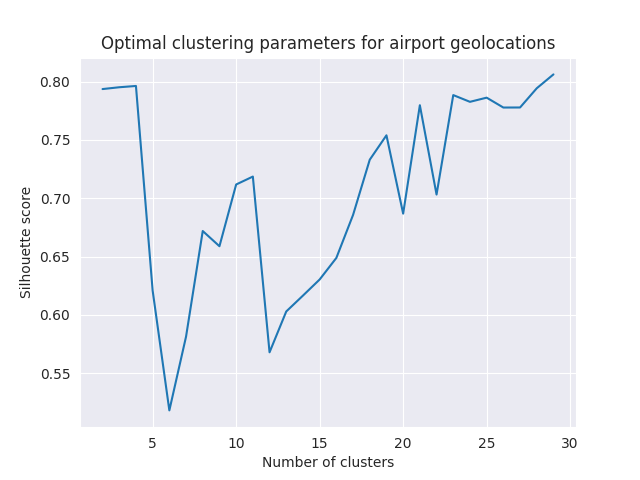

In [69]:
# Plot model results.
fig, ax = plt.subplots()
ax.plot(range(2, 30), silhouette_scores)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Optimal clustering parameters for airport geolocations")
%matplot plt

We can see that 20 is near the elbow of the plot and will be our choice for K.
As this process is stochastic, for a more robust choice, consider running this test multiple times for different starting seeds.

In [46]:
# Create finalized assemblers and clusterers for the 
# preprocessing pipeline.
origin_geo_assembler = ml.feature.VectorAssembler(
    inputCols=["origin_latitude", "origin_longitude"], 
    outputCol="origin_geo_features",
    handleInvalid="keep"
)
origin_geo_kmeans = ml.clustering.KMeans(
        k=20,
        featuresCol="origin_geo_features",
        predictionCol="origin_geo_cluster"
)
# Need to index before one hot encoding so MLeap can infer 
# number of columns created.
origin_geo_indexer = ml.feature.StringIndexer(
    inputCol="origin_geo_cluster", 
    outputCol="origin_geo_idx"
)
# Lastly, one hot encode the cluster values.
origin_geo_encoder = ml.feature.OneHotEncoderEstimator(
    inputCols=["origin_geo_idx"], 
    outputCols=["origin_geo_ohe"]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# Repeat the above actions for the destination.
dest_geo_assembler = ml.feature.VectorAssembler(
    inputCols=["dest_latitude", "dest_longitude"], 
    outputCol="dest_geo_features",
    handleInvalid="keep"
)
dest_geo_kmeans = ml.clustering.KMeans(
        k=20,
        featuresCol="dest_geo_features",
        predictionCol="dest_geo_cluster"
)
dest_geo_indexer = ml.feature.StringIndexer(
    inputCol="dest_geo_cluster", 
    outputCol="dest_geo_idx"
)
dest_geo_encoder = ml.feature.OneHotEncoderEstimator(
    inputCols=["dest_geo_idx"], 
    outputCols=["dest_geo_ohe"]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Continuous variables <a class="anchor" id="continuous"></a>
The continuous variables in our dataset include only the weather data. 
We will be using standardization for all metrics, because weather data is subject to meaningful outliers. 

In [48]:
# Collect all weather columns so standardization can 
# be preformed on all weather features at once.
weather_cols = [
    "origin_tmax", "origin_tmin", "origin_prcp", "origin_snow", "origin_snwd",
    "dest_tmax", "dest_tmin", "dest_prcp", "dest_snow", "dest_snwd"
]
weather_col_assembler = ml.feature.VectorAssembler(
    inputCols=weather_cols, 
    outputCol="weather_features",
    handleInvalid="keep"
)
weather_std_scalar = ml.feature.StandardScaler(
    inputCol="weather_features", 
    outputCol="weather_features_scaled"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Define and fit pipeline <a class="anchor" id="pipeline"></a>

In [49]:
# Collect all the generated features into a single vector.
# THis will be the last stage in the pipeline.
feature_assembler = ml.feature.VectorAssembler(
    inputCols=[
        "day_of_week_ohe",
        "month_ohe",
        "carrier_ohe",
        "origin_geo_ohe",
        "dest_geo_ohe",
        "weather_features_scaled"
    ],
    outputCol="features"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
# Define Pipeline object.
preprocess_pipeline = ml.Pipeline(
    stages=[
        day_of_week_indexer,
        day_of_week_encoder,
        month_indexer,
        month_encoder,
        carrier_indexer,
        carrier_encoder,
        origin_geo_assembler,
        origin_geo_kmeans,
        origin_geo_indexer,
        origin_geo_encoder,
        dest_geo_assembler,
        dest_geo_kmeans,
        dest_geo_indexer,
        dest_geo_encoder,
        weather_col_assembler,
        weather_std_scalar,
        feature_assembler,
    ]
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
# Train the preprocess model and transform the input data.
# Note that the transformed data is cached to avoid recomputation 
# when writing partitions (see below).
preprocess_model = preprocess_pipeline.fit(input_df)
transformed_input_df = preprocess_model.transform(input_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Partition and write data <a class="anchor" id="write-s3"></a>
Partitition input data into train, validation, and test sets and write out files to CSVs in S3 for training models.

In [57]:
# Spliting in train and test set. Note that this operation 
# sorts the data set.
(train_df, validation_df, test_df) = transformed_input_df.randomSplit([0.75, 0.15, 0.10])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [68]:
%%pretty
train_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

arr_delay,cancelled,diverted,day_of_week,month,op_carrier,origin_latitude,origin_longitude,dest_latitude,dest_longitude,origin_tmax,origin_tmin,origin_prcp,origin_snow,origin_snwd,dest_tmax,dest_tmin,dest_prcp,dest_snow,dest_snwd,delay_status,target,day_of_week_ohe,month_ohe,carrier_idx,carrier_ohe,origin_geo_features,origin_geo_cluster,origin_geo_idx,origin_geo_ohe,dest_geo_features,dest_geo_cluster,dest_geo_idx,dest_geo_ohe,weather_features,weather_features_scaled,features
-106.0,0.0,0.0,6,11,AA,40.63980103,-73.77890015,33.94250107,-118.4079971,111.0,28.0,0.0,0.0,0.0,272.0,167.0,0.0,0.0,0.0,OnTime,0.0,"(7,[6],[1.0])","(12,[11],[1.0])",2.0,"(22,[2],[1.0])","[40.63980103,-73....",8,4.0,"(19,[4],[1.0])","[33.94250107,-118...",1,0.0,"(19,[0],[1.0])","(10,[0,1,5,6],[11...","(10,[0,1,5,6],[1....","(89,[6,18,21,45,6..."
-94.0,0.0,0.0,7,2,WN,42.36429977,-71.00520325,38.748697,-90.370003,39.0,-27.0,0.0,0.0,0.0,194.0,44.0,0.0,0.0,0.0,OnTime,0.0,"(7,[],[])","(12,[2],[1.0])",0.0,"(22,[0],[1.0])","[42.36429977,-71....",8,4.0,"(19,[4],[1.0])","[38.748697,-90.37...",2,1.0,"(19,[1],[1.0])","(10,[0,1,5,6],[39...","(10,[0,1,5,6],[0....","(89,[9,19,45,61,7..."
-92.0,0.0,0.0,6,11,DL,40.63980103,-73.77890015,37.61899948120117,-122.375,111.0,28.0,0.0,0.0,0.0,211.0,139.0,0.0,0.0,0.0,OnTime,0.0,"(7,[6],[1.0])","(12,[11],[1.0])",1.0,"(22,[1],[1.0])","[40.63980103,-73....",8,4.0,"(19,[4],[1.0])",[37.6189994812011...,11,7.0,"(19,[7],[1.0])","(10,[0,1,5,6],[11...","(10,[0,1,5,6],[1....","(89,[6,18,20,45,6..."
-89.0,0.0,0.0,6,11,AA,40.63980103,-73.77890015,33.94250107,-118.4079971,111.0,28.0,0.0,0.0,0.0,272.0,167.0,0.0,0.0,0.0,OnTime,0.0,"(7,[6],[1.0])","(12,[11],[1.0])",2.0,"(22,[2],[1.0])","[40.63980103,-73....",8,4.0,"(19,[4],[1.0])","[33.94250107,-118...",1,0.0,"(19,[0],[1.0])","(10,[0,1,5,6],[11...","(10,[0,1,5,6],[1....","(89,[6,18,21,45,6..."
-88.0,0.0,0.0,2,4,YX,40.77719879,-73.87259674,42.36429977,-71.00520325,156.0,50.0,84.0,0.0,0.0,122.0,11.0,84.0,0.0,0.0,OnTime,0.0,"(7,[2],[1.0])","(12,[4],[1.0])",12.0,"(22,[12],[1.0])","[40.77719879,-73....",8,4.0,"(19,[4],[1.0])","[42.36429977,-71....",13,13.0,"(19,[13],[1.0])","[156.0,50.0,84.0,...",[1.50476210731395...,"(89,[2,11,31,45,7..."


The writing operation takes a while. 
It's recommended to increase the number of core nodes in the cluster at this point, if possible.
Alternatively, this code can be run in a Glue Job that transforms the data,
writes the partitions to S3, 
then serializes and saves the processing models.

In [69]:
# Save transformed training data to CSV in S3 by converting to RDD.
train_lines = train_df.rdd.map(
    lambda row: str(row.target) + "," + ",".join(map(str, row.features.toArray()))
)
train_lines.saveAsTextFile(f"s3a://{model_bucket}/preprocessing_output/train/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
# Save transformed training data to CSV in S3 by converting to RDD.
validation_lines = validation_df.rdd.map(
    lambda row: str(row.target) + "," + ",".join(map(str, row.features.toArray()))
)
validation_lines.saveAsTextFile(f"s3a://{model_bucket}/preprocessing_output/validation/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
# Repeat the same saving method for the test data.
test_lines = test_df.rdd.map(
    lambda row: str(row.target) + "," + ",".join(map(str, row.features.toArray()))
)
test_lines.saveAsTextFile(f"s3a://{model_bucket}/preprocessing_output/test/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Serialize and store pipelines <a class="anchor" id="store-pipeline"></a>
Spark pipelines and estimators must be serialized with MLeap to use with a Sagemaker model.
Sagemaker will then read the model from S3 to use with a built SparkML image.

In [64]:
# Serialize preproccesing pipeline.
serializer = support.SimpleSparkSerializer()
serializer.serializeToBundle(
    preprocess_model, 
    "jar:file:/tmp/preprocess.zip", 
    transformed_input_df
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [65]:
# Convert model zipfile to tarfile.
with zipfile.ZipFile("/tmp/preprocess.zip") as zf:
    zf.extractall("/tmp/preprocess")

with tarfile.open("/tmp/preprocess.tar.gz", "w:gz") as tar:
    tar.add("/tmp/preprocess/bundle.json", arcname="bundle.json")
    tar.add("/tmp/preprocess/root", arcname="root")

# Write model to S3.
s3 = boto3.resource("s3")
filename = "spark_preprocessor/model.tar.gz"
s3.Bucket(model_bucket).upload_file("/tmp/preprocess.tar.gz", filename)

# Clean up local environment.
os.remove("/tmp/preprocess.zip")
os.remove("/tmp/preprocess.tar.gz")
shutil.rmtree("/tmp/preprocess")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
# Serialize postproccesing pipeline.
serializer = support.SimpleSparkSerializer()
serializer.serializeToBundle(
    target_idx_decoder, 
    "jar:file:/tmp/postprocess.zip", 
    transformed_input_df
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# Convert model zipfile to tarfile.
with zipfile.ZipFile("/tmp/postprocess.zip") as zf:
    zf.extractall("/tmp/postprocess")

with tarfile.open("/tmp/postprocess.tar.gz", "w:gz") as tar:
    tar.add("/tmp/postprocess/bundle.json", arcname="bundle.json")
    tar.add("/tmp/postprocess/root", arcname="root")

# Write model to S3.
s3 = boto3.resource("s3")
filename = "spark_postprocessor/model.tar.gz"
s3.Bucket(model_bucket).upload_file("/tmp/postprocess.tar.gz", filename)

# Clean up local environment.
os.remove("/tmp/postprocess.zip")
os.remove("/tmp/postprocess.tar.gz")
shutil.rmtree("/tmp/postprocess")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…